In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from algorithms import ChainTopology, RingTopology, QuadraticsTask, relaysum_model, relaysum_grad, relaysum_mix, all_reduce, gossip, d2, gradient_tracking, BinaryTreeTopology, relaysum_grad_overlap
from random_quadratics import RandomQuadraticsTask
import torch
import math
import tuning
import pandas as pd
from warehouse import Warehouse

In [21]:
torch.set_default_dtype(torch.float64)

# Reach a fixed plateau

In [22]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01, 1]
max_steps = [200, 500, 2000]
eval_intervals = [2, 5, 20]
plateau = 1e-6
seed = 0

In [23]:
warehouse = Warehouse()

In [24]:
algorithm_name = "Gossip"
algorithm = gossip
topology_name = "ring"
topology = RingTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
5.027451938842201e-13
Tuning for 0.01
8.776453727932232e-07
Tuning for 1
0.0014456269036839942


In [25]:
algorithm_name = "RelaySGD/Grad"
algorithm = relaysum_grad
topology_name = "chain"
topology = ChainTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
7.337735926317597e-11
Tuning for 0.01
2.0265183017786903e-08
Tuning for 1
8.653164309535555e-07


In [26]:
algorithm_name = "RelaySGD"
algorithm = relaysum_model
topology_name = "chain"
topology = ChainTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

51 0.869140625
5.317038806262599e-10
51 0.869140625
9.848753756980244e-13
50 0.8837890625
9.590106486712102e-13


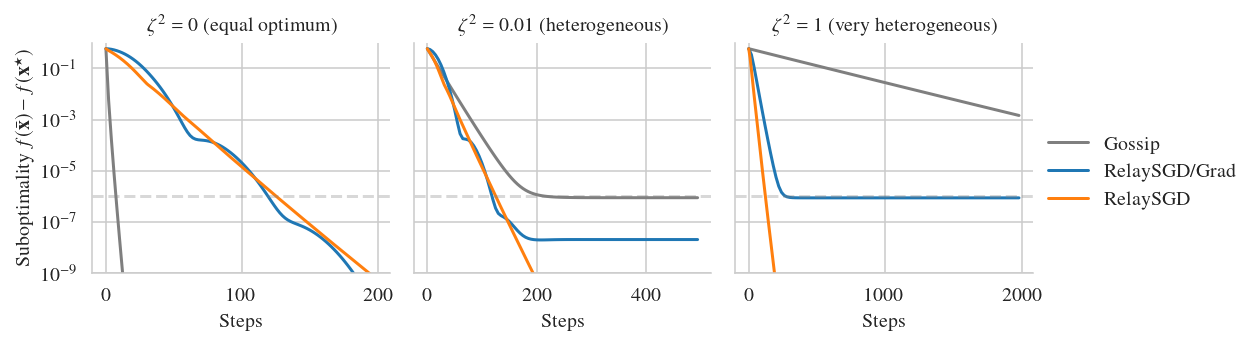

In [28]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
})

colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]
sns.set_palette(colors)

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", 1: "1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False);
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
g.set(ylim=[1e-9, 1])
g.add_legend(title="");

In [29]:
g.savefig("model_vs_grad_curves.pdf", bbox_inches="tight")